<a href="https://colab.research.google.com/github/Hc1023/colab/blob/master/MNIST_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

修改自[classifier_sample]('https://github.com/Hc1023/colab/blob/master/classifier_sample.ipynb')，数据集从CIFAR变为MNIST，不同之处：1.CIFAR是三通道的而MNIST是单通道的； 2.网络的参数需要变动。

同时，这是classifier_sample的进化版，全面实现了一个分类器应该做的事情，而前者只进行了训练。

且可与[MNIST_in_Keras](https://github.com/Hc1023/colab/blob/master/MNIST_in_Keras.ipynb)对比



## Loading MNIST

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=True)


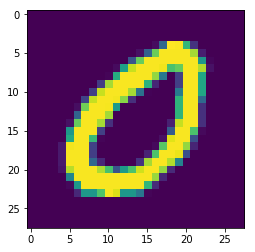

digit label:0


In [168]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

images = images[0].numpy().squeeze(0)
plt.imshow(images)
plt.show()
print('digit label:{}'.format(labels.numpy()[0]))

In [0]:
#define an averagemeter for convenience
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


## Define a Convolutional Neural Network

In [0]:
import torch.nn as nn
import torch.nn.functional as F

#   def __init__(self, in_channels, out_channels, kernel_size, stride,
#                  padding, dilation, transposed, output_padding,
#                  groups, bias, padding_mode)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        #x.shape=(4,1,28,28)
        x = self.pool(F.relu(self.conv1(x)))
        #x.shape=(4,6,24,24) -> (4,6,12,12)
        x = self.pool(F.relu(self.conv2(x)))
        #x.shape=(4,16,8,8) -> (4,16,4,4)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

## Define a Loss function and optimizer

学习率大，学习速度快，使用时间点通常为刚开始训练时，副作用：1.易损失值爆炸；2.易振荡。

学习率小，学习速度慢，使用时间点通常为一定轮数过后，副作用：1.易过拟合；2.收敛速度慢。

在训练过程中，一般根据训练轮数设置动态变化的学习率。

- 刚开始训练时：学习率以 0.01 ~ 0.001 为宜。
- 一定轮数过后：逐渐减缓。
- 接近训练结束：学习速率的衰减应该在100倍以上。

In [183]:
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

device: cuda


## Train the network

In [0]:
def train(model, device, trainloader, optimizer, epoch):
    losses = AverageMeter()
    model.train()
    begin = time.time()
    for index, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs, labels
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.update(float(loss.item()), inputs.size(0))

    end = time.time()
    #print("Epoch:{} Train set: time cost:{:.4f}".format(epoch, end - begin))
    print("Epoch:{} Train set: time cost:{:.4f}, train loss:{:.4f}"
         .format(epoch, end - begin, losses.avg))

In [0]:
def test(model, device, testloader, optimizer, epoch):
    model.eval()
    losses = AverageMeter()
    correct = 0
    for index, (inputs, labels) in enumerate(testloader, 0):
      inputs, labels = inputs.to(device), labels.to(device)
      with torch.no_grad():
            outputs = model(inputs)
      loss = F.cross_entropy(outputs, labels)
      losses.update(float(loss.item()), inputs.size(0))
      pred = outputs.argmax(dim=1, keepdim=True)
      correct += pred.eq(labels.view_as(pred)).sum().item()
    
    accuracy=correct / len(testloader.dataset)
    print('Epoch:{} Test set: Average loss: {:.4f}, Accuracy: {:.4f}\n'.format(epoch, losses.avg, accuracy))

In [184]:
epochs=20
for epoch in range(epochs):
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader, optimizer, epoch)

print('Finished Training')

Epoch:0 Train set: time cost:7.6884, train loss:2.2969
Epoch:0 Test set: Average loss: 2.2647, Accuracy: 0.3722

Epoch:1 Train set: time cost:7.6408, train loss:1.7562
Epoch:1 Test set: Average loss: 1.5668, Accuracy: 0.9109

Epoch:2 Train set: time cost:7.6988, train loss:1.5487
Epoch:2 Test set: Average loss: 1.5221, Accuracy: 0.9460

Epoch:3 Train set: time cost:7.5835, train loss:1.5214
Epoch:3 Test set: Average loss: 1.5079, Accuracy: 0.9572

Epoch:4 Train set: time cost:7.6437, train loss:1.5083
Epoch:4 Test set: Average loss: 1.5007, Accuracy: 0.9633

Epoch:5 Train set: time cost:7.5429, train loss:1.5008
Epoch:5 Test set: Average loss: 1.4940, Accuracy: 0.9701

Epoch:6 Train set: time cost:7.5940, train loss:1.4963
Epoch:6 Test set: Average loss: 1.4915, Accuracy: 0.9721

Epoch:7 Train set: time cost:7.6019, train loss:1.4930
Epoch:7 Test set: Average loss: 1.4886, Accuracy: 0.9748

Epoch:8 Train set: time cost:7.5899, train loss:1.4904
Epoch:8 Test set: Average loss: 1.4879, A

In [0]:
torch.save(model.state_dict(),'checkpoint.pth.tar')
checkpoint = torch.load('checkpoint.pth.tar')

In [188]:
checkpoint

OrderedDict([('conv1.weight',
              tensor([[[[ 0.1120, -0.1818, -0.3815, -0.3477, -0.2356],
                        [ 0.0778, -0.0275, -0.1055, -0.3002, -0.3463],
                        [ 0.4291,  0.1611, -0.1824, -0.0390,  0.0178],
                        [ 0.5688,  0.4321,  0.4097,  0.3269,  0.3142],
                        [ 0.2474,  0.5274,  0.3679,  0.3480,  0.3795]]],
              
              
                      [[[-0.0421,  0.0036,  0.2248,  0.2329,  0.4233],
                        [ 0.4835,  0.5937,  0.6797,  0.5917,  0.5610],
                        [ 0.4331,  0.6807,  0.6013,  0.3720,  0.2819],
                        [ 0.2986,  0.0139,  0.0739,  0.0594, -0.1047],
                        [-0.2827,  0.0915, -0.3065, -0.2918, -0.2872]]],
              
              
                      [[[ 0.0959, -0.1259, -0.0658,  0.0790, -0.3051],
                        [ 0.2999, -0.0333, -0.3032, -0.1910, -0.2576],
                        [ 0.0930,  0.0144,  0.0608, -0